In [35]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import shapely as shp

In [9]:
import CutLineSimplified
import CutLineSimplified.core
import CutLineSimplified.core.tensile_test_series

In [10]:
path = r"..\..\data_test"

paths = [el for el in os.listdir(path) if "hdf5" in el]
paths_rel = [os.path.join(path, a_path) for a_path in paths]

tensiletest_series = CutLineSimplified.core.tensile_test_series.TensileTestSeries.load_from_paths(paths_rel)

In [11]:
this_tensile = tensiletest_series.tensile_tests[0]
dic_result = tensiletest_series.tensile_tests[0].dic_results

In [12]:
x = dic_result.coords[-1, :, 0]
left_side = x <= x.min() + 5
right_side = x >= x.max() - 5
all = np.ones_like(x, dtype=bool)
avg_x_l = np.average(x[left_side])
avg_x_r = np.average(x[right_side])

In [13]:
y_middle = []

for a_loc in [left_side, right_side, all]:
	y = dic_result.coords[-1, a_loc, 1]
	e_yy = dic_result.strains[-1, a_loc, 1]
	y_min, y_max = np.min(dic_result.coords[-1, :, 1]), np.max(dic_result.coords[-1, :, 1])
	y_iter = np.linspace(y_min, y_max, num=100, endpoint=True)
	s_w = 0.75
	norm_r = (np.outer(np.ones_like(y), y_iter) - np.outer(y, np.ones_like(y_iter)))**2
	W_line_r = 1/(s_w*np.sqrt(2*np.pi)) * np.exp(-norm_r/(2*s_w**2))
	e_yy_iter = np.einsum("ij, i -> j", W_line_r, e_yy) / np.sum(W_line_r, axis=0)
	y_middle.append(y_iter[np.argmax(e_yy_iter)])

In [14]:
y_middle
dx = avg_x_l - avg_x_r
dy = y_middle[0] - y_middle[1]
m = dy/dx
m

-0.4624345022526086

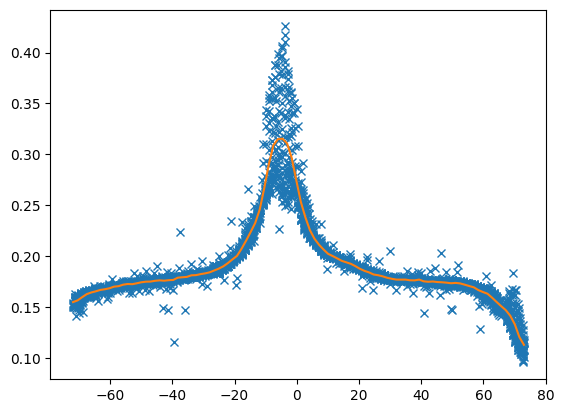

In [15]:
fig, ax = plt.subplots()
ax.plot(y,e_yy, "x")
ax.plot(y_iter,e_yy_iter)

In [72]:
x_cut = np.array((x.min(), x.max()))
y_cut = y_middle[-1] + m*x_cut

In [96]:
item = 0
len_item = -1
for i in range(len(dic_result.mesh_holes)):
	if len(dic_result.mesh_holes[i]) > len_item:
		item = i
		len_item = len(dic_result.mesh_holes[i])

mesh_outside_boundary = dic_result.mesh_holes[item]
mesh_outside_boundary = np.array(mesh_outside_boundary)[:, 0]
x_bound = dic_result.coords[-1, mesh_outside_boundary][:, [0,1]]
shape = shp.Polygon(x_bound)

In [97]:
x_cut = np.array((x.min(), x.max()))
y_cut = y_middle[-1] + m*x_cut
line = shp.LineString(np.array((x_cut, y_cut)).T)
line = line.intersection(shape)
x_cut = np.linspace(line.coords[0][0], line.coords[-1][0], endpoint=True, num=100)
y_cut = np.linspace(line.coords[0][1], line.coords[-1][1], endpoint=True, num=100)

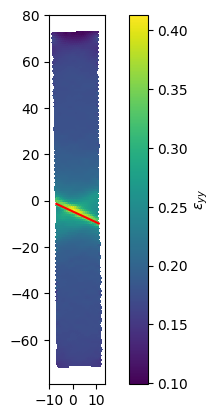

In [98]:
fig, ax = plt.subplots()
this_tensile.plot_on_ax(ax,timestep=-1, keyword="eps_yy")
ax.set_aspect("equal")
ax.plot(x_cut, y_cut, "r")

In [99]:
duy = np.diff(dic_result.coords[:, :, 1], axis=0)
dux = np.diff(dic_result.coords[:, :, 0], axis=0)

In [100]:
x = dic_result.coords[:, :, 0]
y = dic_result.coords[:, :, 1]

y_cut_all = [y_cut,]
x_cut_all = [x_cut,]

for i in range(len(duy)-1, -1, -1):
	y_cut_prec = y_cut_all[-1]
	x_cut_prec = x_cut_all[-1]
	norm_r = (np.outer(np.ones_like(x[i]), x_cut_prec) - np.outer(x[i], np.ones_like(x_cut_prec)))**2 + \
	         (np.outer(np.ones_like(y[i]), y_cut_prec) - np.outer(y[i], np.ones_like(y_cut_prec)))**2
	W_line_r = 1/(s_w*np.sqrt(2*np.pi)) * np.exp(-norm_r/(2*s_w**2))
	y_cut_actual = y_cut_prec - np.einsum("ij, i -> j", W_line_r, duy[i]) / np.sum(W_line_r, axis=0)
	x_cut_actual = x_cut_prec - np.einsum("ij, i -> j", W_line_r, dux[i]) / np.sum(W_line_r, axis=0)
	y_cut_all.append(y_cut_actual)
	x_cut_all.append(x_cut_actual)

y_cut_all = y_cut_all[::-1]
x_cut_all = x_cut_all[::-1]

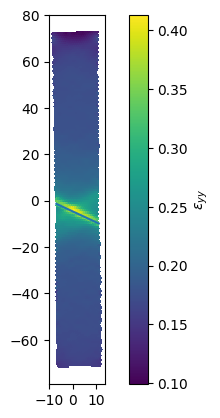

In [101]:
timestep = -1
fig, ax = plt.subplots()
this_tensile.plot_on_ax(ax,timestep=timestep, keyword="eps_yy")
ax.set_aspect("equal")
ax.plot(x_cut_all[timestep], y_cut_all[timestep])

In [109]:
np.stack((x_cut_all, y_cut_all)).swapaxes(0, 1).swapaxes(1,-1).shape

(882, 100, 2)